# homework 4: bootstrapping

In [34]:
using DataFrames
using CSV
using PyPlot
using Random
using StatsBase
using Statistics
using PyCall
using Printf
sns = pyimport("seaborn")                                

# (optional) change the max width of columns of `DataFrame`
#  that are displayed in the Juptyer Notebook.
ENV["COLUMNS"] = 300 # characters;

## bicycle rentals

You own a popular bicycle rental company near the Golden Gate Bridge that operates during the summer only. Hundreds of people rent your bicycles each day to ride over the Golden Gate bridge and around the park, and then they return their rented bicycle. To assess your inventory for a future surge in demand, you want to know the average duration that people rent your bicycles. Because it is too tedious to record the exact times that *every* bicycle (i.e. the entire population of bicycle renters) was rented and returned, you instead select a random sample of renters over the summer and record the duration that they rented their bicycle. You also record the weather that day-- whether it was cool or hot-- because you are interested in if the weather affects the mean duration that bicycles are rented.

(1) In `bicycle_rides.csv`, each row corresponds to the rental and subsequent return of a bicycle. The `:duration` column gives the duration, in minutes, that the bicycle was rented. The `:weather` column tells us whether the day was hot or cool. Read in the CSV file as a `DataFrame`, `df`, and display only the first 5 rows.

In [2]:
df = CSV.read("bicycle_rides.csv", copycols=true)
first(df, 5)

,duration,weather
,Float64,String
1,55.5,cool
2,54.2,cool
3,4.4,cool
4,29.1,hot
5,45.1,hot


(2) how many rentals of bicycles are represented in this sample?

In [3]:
num_rentals = nrow(df)
println("There are $num_rentals bicycles in this sample.")

There are 299 bicycles in this sample.


(3) use the `by` function to group by the weather on the day of the rental, find the number of bike rides in the data set that took place with that kind of weather, then assign this to be a new column `nb_rides`. i.e. create a new `DataFrame`:

```
   weather    nb_rides
     cool        x
     hot         y
```
where `x` and `y` are integers denoting the number of bicycle rentals in the sample during cool and hot days, respectively.

In [4]:
df_num_rides = by(df, :weather, nb_rides=:weather => length)
df_num_rides

,weather,nb_rides
,String,Int64
1,cool,118
2,hot,181


(4) Make a data visualization that compares the empirical distribution of the duration of bike rides on cold vs. hot days.
* use one big plot with two panels
* plot on panel `i` the histogram of durations of bike rides when the weather is `weathers[i]` for `i=1:2` and `weathers = ["cool", "hot"]`
* the two panels should have an identical x- and y-axis scale for a fair comparison
* the two histograms should use the same bin placements/widths for a fair comparison
* label each panel with a title corresponding to whether the weather was cool or hot
* use x- and y-axis labels
* use the color blue for the histogram corresponding to cool days and red for hot days
* use a `for` loop to make the plot

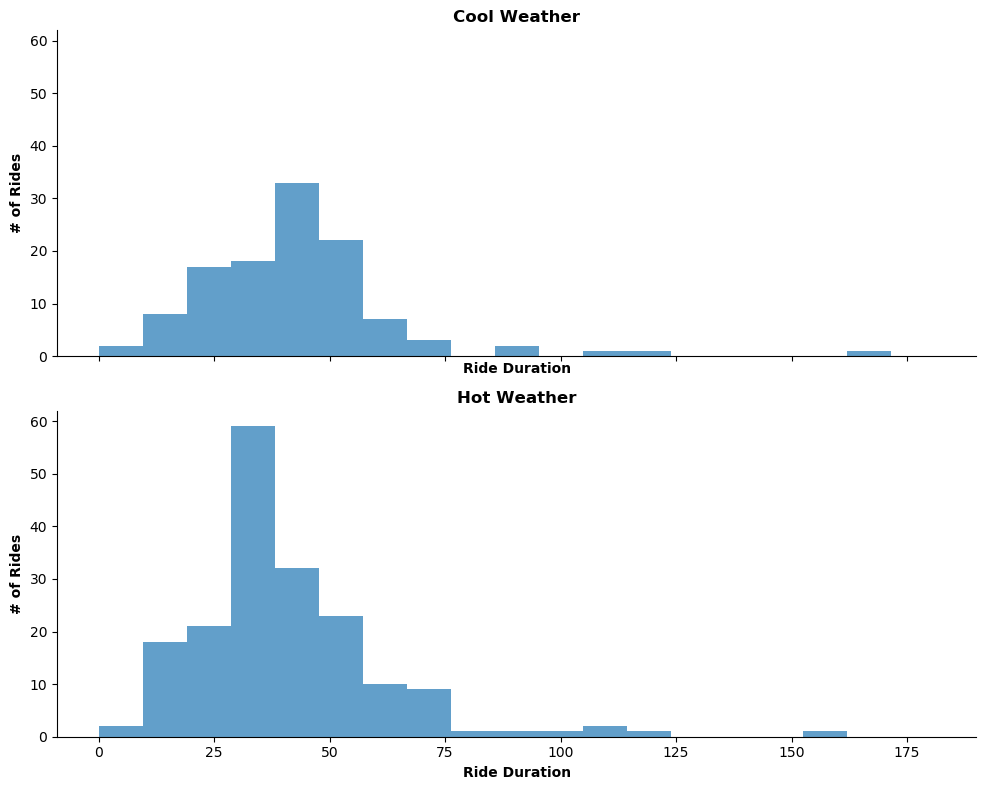

In [5]:
fig, ax = subplots(
    2, 
    1, 
    figsize=(10, 8), 
    sharex=true,
    sharey=true,
    tight_layout=true
)
sns.despine()

grouped = groupby(df, :weather)
bins = range(0, stop=maximum(df_num_rides.nb_rides), length=20)

for (i, weather) in enumerate(["cool", "hot"])
    @assert grouped[i].weather[1] == weather
    ax[i].hist(grouped[i].duration, alpha=0.7, bins=bins)
    ax[i].set_xlabel("Ride Duration", weight="bold")
    ax[i].set_ylabel("# of Rides", weight="bold")
    ax[i].set_title(titlecase("$weather weather"), weight="bold")
    # this would look pretty good as a text object instead of a title because
    # you could get the plots closer together... also you'd only really need
    # one xlabel
#     x_pos = 175
#     y_pos = 55
#     ax[i].text(
#         x_pos, 
#         y_pos,
#         titlecase("$weather weather"),
#         va="top",
#         ha="right",
#         weight="bold",
#         size=48,
#         color="C0",
#         alpha=0.4
#     )
end
# ax[2].set_xlabel("Ride Duration", weight="bold")
# fig.suptitle("Weather vs. Duration Comparison")

(5) does one distribution appear shifted to the right of the other? use the `by` function to group the `df` from (1) by weather, compute the mean duration of a bike ride in that kind of weather, and assign the result to be a new column `:mean_duration`. i.e. create a new `DataFrame`:

```
   weather    mean_duration
     cool        x
     hot         y
```
where `x` and `y` are floating points denoting the mean bicycle ride duration on cool and hot days, respectively.

In [6]:
df_mean = by(df, :weather, mean_duration=:duration => mean)

,weather,mean_duration
,String,Float64
1,cool,46.6712
2,hot,40.3066


(6) write a function `run_bootstrap` that takes in three arguments:
* `df::DataFrame` the entire bicycle rides `DataFrame` that you loaded in from (1)
* `weather::String` either "cool" or "warm"
* `nb_sims::Int` the number of times to draw a bootstrap sample to characterize the bootstrap empirical distribution of the sample mean duration of a bike ride = number of simulations of sampling the population

and does the following inside the function:

* creates a new `DataFrame`, `df_w`, with all the rows corresponding to bike rides taking place in `weather` weather.
* draws `nb_sims` bootstrap samples of bicycle rides in `weather` weather and computes the bootstrap sample mean of bicycle ride durations in `weather` weather. `df_w` will facilitate this. store these bootstrap sample means in an `Array{Float64}`
* return the array of the bootstrap sample means. this array is of length `nb_sims`.

test out your function by calling:
```julia
run_bootstrap(df, "cool", 100)
```
make sure you return an array of 100 (different) values that hover around the mean from (5).

In [43]:
function run_bootstrap(df::DataFrame, weather::String, nb_sims::Int)
    df_w = filter(row -> occursin(row[:weather], weather), df)
    num_samples = nrow(df_w)
    sample_means = ones(nb_sims) * NaN
    for i in 1:nb_sims
        sample_means[i] = mean(
            sample(
                df_w.duration, 
                num_samples, 
                replace=true, 
                ordered=false
            )
        )
    end
    return sample_means
end

cool_mean = filter(row -> row[:weather] == "cool", df_mean)[1, :mean_duration]
sim_means = run_bootstrap(df, "cool", 100)
num_sims = length(sim_means)
sim_mean = mean(sim_mean)
off_by = abs(sim_mean - cool_mean) / cool_mean * 100
println("Simulated mean: $sim_mean ($num_sims samples)")
@printf("Simulated mean off by %0.2f%%", off_by)

Simulated mean: 46.39427966101695 (100 samples)
Simulated mean off by 0.59%

(7) write a function `confidence_interval` that takes in the following arguments:
* `bootstrap_means::Array{Float64}`: an array of bootstrap sample means that is output from `run_bootstrap` above.
* `confidence::Float64`: the desired confidence level, e.g. 95.0 for a 95% confidence level.

and returns a two-element array giving the interval estimate for the mean bicycle duration in a certain type of weather.

test your function by, e.g.:
```julia
bootstrap_means = run_bootstrap(df, "cool", 100)
ci = confidence_interval(bootstrap_means, 95.0) # returns [42.2, 53.4] but will differ from run to run 
```

In [80]:
function confidence_interval(
        bootstrap_means::Array{Float64}, 
        confidence::Float64
)
    return [
        percentile(bootstrap_means, 100-confidence), 
        percentile(bootstrap_means, confidence)
    ]
end

bootstrap_means = run_bootstrap(df, "cool", 100)
confidence_interval(bootstrap_means, 95.0)

2-element Array{Float64,1}:
 42.0065254237288 
 51.60610169491527

(8) use your `run_bootstrap` and `confidence_interval` functions to, finally:
* visualize the bootstrap empirical distribution of the sample mean bicycle ride duration in each type of weather (for cool, hot weather) in two different panels much like in (4). again, the scales on the x- and y-axes should be the identical for a fair comparison.
* plot as a vertical line the sample mean bicycle ride duration in that type of weather
* highlight, as we did in lecture, the 95% confidence interval on the x-axis of the two panels, corresponding to the interval estimate for the mean bicycle ride duration in that type of weather. hint: `plot(ci, [0, 0], lw=6)` where `lw` is for line width.
* use the color blue for lines/bars in the "cool" weather panel and the color red for the "hot" weather panel. I think it looks nice if you use `alpha=0.3` for the histograms and non-transparent colors for the vertical line/confidence interval.

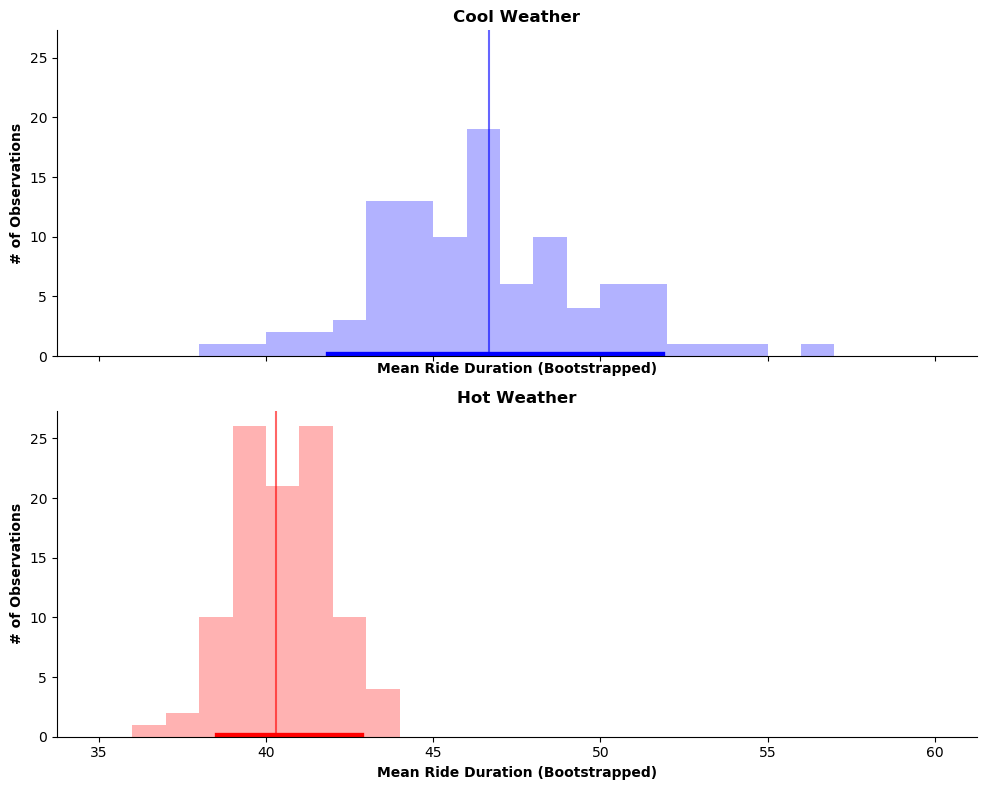

In [121]:
fig, ax = subplots(
    2, 
    1, 
    figsize=(10, 8), 
    sharex=true,
    sharey=true,
    tight_layout=true
)
sns.despine()
colors = Dict("cool" => "b", "hot" => "r")

grouped = groupby(df, :weather)
bins = range(35, stop=60, length=26)

for (i, weather) in enumerate(["cool", "hot"])
    @assert grouped[i].weather[1] == weather
    
    bootstrap_means = run_bootstrap(df, weather, 100)
    ci = confidence_interval(bootstrap_means, 95.0)
    
    ax[i].plot(ci, [0, 0], lw=6, color=colors[weather])
    ax[i].axvline(
        filter(row -> row[:weather] == weather, df_mean)[1, :mean_duration],
        color=colors[weather], 
        alpha=0.6
    )
    ax[i].hist(bootstrap_means, alpha=0.3, bins=bins, color=colors[weather])
    ax[i].set_xlabel("Mean Ride Duration (Bootstrapped)", weight="bold")
    ax[i].set_ylabel("# of Observations", weight="bold")
    ax[i].set_title(titlecase("$weather weather"), weight="bold")
end

(9) the width of the bootstrap empirical distribution of the sample mean bicycle ride duration is wider in one type of weather than the other... can you explain this?

(10) judging from the 95% confidence intervals, what do you think would be the outcome of a permutation test of the following two hypotheses with a significance level of $\alpha=0.05$?

**null hypothesis**: the mean duration of a bicycle ride on a hot day is 40 min

**alternative hypothesis**: the mean duration of a bicycle ride on a hot day is not 40 min

Choose one answer:<br>
(a) null hypothesis rejected<br>
(b) fail to reject the null hypothesis<br>
(c) I can't tell you from looking at my plot from (8), I'd have to actually do the permutation test to be sure.

A helpful resource for answering this: "Using a Confidence Interval to Test Hypotheses" [here](https://www.inferentialthinking.com/chapters/13/4/Using_Confidence_Intervals.html).

(10) judging from the 95% confidence intervals, what do you think would be the outcome of a permutation test of the following two hypotheses with a significance level of $\alpha=0.05$?

**null hypothesis**: there is no difference in the mean duration of a bicycle ride on a hot vs. cool day

**alternative hypothesis**: the mean bicycle ride duration is higher on a cool day than a hot day.

Choose one answer:<br>
(a) null hypothesis rejected<br>
(b) fail to reject the null hypothesis<br>
(c) I can't tell you from looking at my plot from (8), I'd have to actually do the permutation test.

A helpful resource for answerin this: [this](https://core.ac.uk/download/pdf/82702323.pdf) and [this](https://blog.minitab.com/blog/real-world-quality-improvement/common-statistical-mistakes-you-should-avoid).

### etymology for curious readers

[bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping)